## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
from keras import optimizers
import itertools

# 防止調用 GPU 報錯：Blas GEMM launch failed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.9 #佔用 GPU 多少比例的記憶體資源
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# 繪製結果
import matplotlib.pyplot as plt
%matplotlib inline

def showPicture(results):
    color_bar = ["r", "g", "b", "y", "m", "k"]

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
OPTIMIZERS = ['sgd','adam','RMSprop']
SGD_MOMENTUM = 0.95
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999
RMSPROP_RHO = 0.9
FACTOR = [0.3, 0.5, 0.8]
PATIENCE = [10, 30]



Experiment with optimizer = sgd, factor = 0.3, patience = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normali

50000/50000 [==============================] - 2s 47us/step - loss: 0.6695 - acc: 0.7970 - val_loss: 1.5192 - val_acc: 0.4965
Epoch 49/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.6681 - acc: 0.7983 - val_loss: 1.5209 - val_acc: 0.4959
Epoch 50/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.6655 - acc: 0.7990 - val_loss: 1.5225 - val_acc: 0.4969


Experiment with optimizer = sgd, factor = 0.3, patience = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_

50000/50000 [==============================] - 2s 48us/step - loss: 0.5644 - acc: 0.8341 - val_loss: 1.6601 - val_acc: 0.4841
Epoch 47/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.5483 - acc: 0.8405 - val_loss: 1.6491 - val_acc: 0.4913
Epoch 48/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.5307 - acc: 0.8472 - val_loss: 1.6508 - val_acc: 0.4874
Epoch 49/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.5154 - acc: 0.8529 - val_loss: 1.6612 - val_acc: 0.4851

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 50/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.4908 - acc: 0.8651 - val_loss: 1.6629 - val_acc: 0.4899


Experiment with optimizer = sgd, factor = 0.5, patience = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)     

Epoch 43/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.7375 - acc: 0.7674 - val_loss: 1.5150 - val_acc: 0.5017
Epoch 44/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.7324 - acc: 0.7705 - val_loss: 1.5118 - val_acc: 0.5005
Epoch 45/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.7263 - acc: 0.7723 - val_loss: 1.5179 - val_acc: 0.4990
Epoch 46/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.7224 - acc: 0.7732 - val_loss: 1.5272 - val_acc: 0.5011
Epoch 47/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.7159 - acc: 0.7768 - val_loss: 1.5207 - val_acc: 0.4991
Epoch 48/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.7128 - acc: 0.7768 - val_loss: 1.5224 - val_acc: 0.5011

Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 49/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.7041 - ac

Epoch 41/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.6505 - acc: 0.7999 - val_loss: 1.5855 - val_acc: 0.4947
Epoch 42/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.6342 - acc: 0.8052 - val_loss: 1.5757 - val_acc: 0.4897
Epoch 43/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.6166 - acc: 0.8129 - val_loss: 1.5774 - val_acc: 0.4902
Epoch 44/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.5971 - acc: 0.8208 - val_loss: 1.6004 - val_acc: 0.4934
Epoch 45/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.5791 - acc: 0.8278 - val_loss: 1.6101 - val_acc: 0.4895
Epoch 46/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.5630 - acc: 0.8347 - val_loss: 1.6333 - val_acc: 0.4885
Epoch 47/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.5474 - acc: 0.8402 - val_loss: 1.6287 - val_acc: 0.4860
Epoch 48/50
50000/50000 [=========

50000/50000 [==============================] - 2s 47us/step - loss: 0.7114 - acc: 0.7768 - val_loss: 1.5126 - val_acc: 0.4988
Epoch 39/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.6970 - acc: 0.7821 - val_loss: 1.5269 - val_acc: 0.5013
Epoch 40/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.6798 - acc: 0.7894 - val_loss: 1.5383 - val_acc: 0.5016
Epoch 41/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.6642 - acc: 0.7952 - val_loss: 1.5322 - val_acc: 0.4982
Epoch 42/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.6503 - acc: 0.8007 - val_loss: 1.5370 - val_acc: 0.4959
Epoch 43/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.6356 - acc: 0.8069 - val_loss: 1.5843 - val_acc: 0.4900

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 44/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.6168 - acc: 0.8140 - 

Epoch 36/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.7437 - acc: 0.7617 - val_loss: 1.5292 - val_acc: 0.4943
Epoch 37/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.7267 - acc: 0.7699 - val_loss: 1.5412 - val_acc: 0.4987
Epoch 38/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.7077 - acc: 0.7762 - val_loss: 1.5458 - val_acc: 0.4912
Epoch 39/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.6888 - acc: 0.7845 - val_loss: 1.5540 - val_acc: 0.4943
Epoch 40/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.6718 - acc: 0.7900 - val_loss: 1.5432 - val_acc: 0.4955
Epoch 41/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.6525 - acc: 0.7979 - val_loss: 1.5720 - val_acc: 0.4916
Epoch 42/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.6359 - acc: 0.8028 - val_loss: 1.5778 - val_acc: 0.4915
Epoch 43/50
50000/50000 [=========

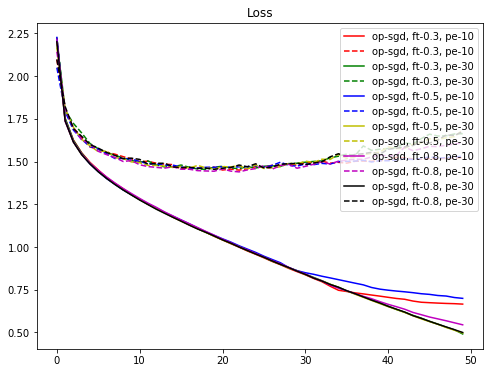

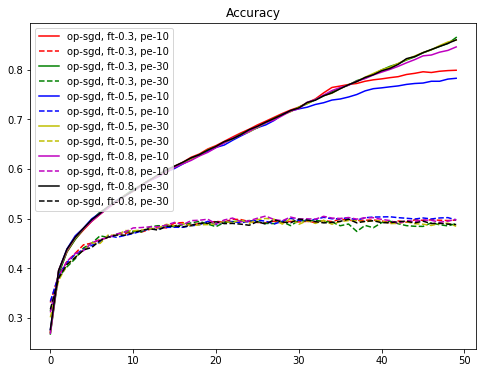



Experiment with optimizer = adam, factor = 0.3, patience = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normal

Epoch 48/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.1108 - acc: 0.9876 - val_loss: 2.0259 - val_acc: 0.5215
Epoch 49/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.1101 - acc: 0.9878 - val_loss: 2.0222 - val_acc: 0.5240
Epoch 50/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.1090 - acc: 0.9891 - val_loss: 2.0267 - val_acc: 0.5214


Experiment with optimizer = adam, factor = 0.3, patience = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
____________________________________________________________

Epoch 46/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.0443 - acc: 0.9973 - val_loss: 2.3678 - val_acc: 0.5145
Epoch 47/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.0418 - acc: 0.9974 - val_loss: 2.3854 - val_acc: 0.5156
Epoch 48/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.0394 - acc: 0.9980 - val_loss: 2.4286 - val_acc: 0.5142
Epoch 49/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.0368 - acc: 0.9980 - val_loss: 2.4270 - val_acc: 0.5119
Epoch 50/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.0341 - acc: 0.9984 - val_loss: 2.4812 - val_acc: 0.5145


Experiment with optimizer = adam, factor = 0.5, patience = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
________________________________________________

Epoch 43/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1101 - acc: 0.9881 - val_loss: 2.0828 - val_acc: 0.5096
Epoch 44/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.1065 - acc: 0.9891 - val_loss: 2.0916 - val_acc: 0.5126
Epoch 45/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.1018 - acc: 0.9894 - val_loss: 2.1117 - val_acc: 0.5128
Epoch 46/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.0983 - acc: 0.9906 - val_loss: 2.1297 - val_acc: 0.5167
Epoch 47/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.0947 - acc: 0.9913 - val_loss: 2.1613 - val_acc: 0.5119

Epoch 00047: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 48/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.0851 - acc: 0.9939 - val_loss: 2.1210 - val_acc: 0.5155
Epoch 49/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.0825 - acc

Epoch 41/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.1761 - acc: 0.9454 - val_loss: 2.7665 - val_acc: 0.4531
Epoch 42/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1607 - acc: 0.9519 - val_loss: 2.8445 - val_acc: 0.4645
Epoch 43/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1569 - acc: 0.9515 - val_loss: 2.8813 - val_acc: 0.4618
Epoch 44/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.1448 - acc: 0.9569 - val_loss: 2.9537 - val_acc: 0.4517

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 45/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.0858 - acc: 0.9809 - val_loss: 2.5892 - val_acc: 0.4989
Epoch 46/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.0477 - acc: 0.9948 - val_loss: 2.5843 - val_acc: 0.5064
Epoch 47/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.0383 - ac

50000/50000 [==============================] - 2s 47us/step - loss: 0.1293 - acc: 0.9731 - val_loss: 2.3577 - val_acc: 0.4812
Epoch 38/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.1208 - acc: 0.9754 - val_loss: 2.4767 - val_acc: 0.4879
Epoch 39/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1148 - acc: 0.9769 - val_loss: 2.5017 - val_acc: 0.4899
Epoch 40/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.1096 - acc: 0.9778 - val_loss: 2.6038 - val_acc: 0.4823
Epoch 41/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.0974 - acc: 0.9819 - val_loss: 2.5485 - val_acc: 0.4840
Epoch 42/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.0875 - acc: 0.9852 - val_loss: 2.6071 - val_acc: 0.4874
Epoch 43/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.0818 - acc: 0.9862 - val_loss: 2.6451 - val_acc: 0.4784

Epoch 00043: ReduceLROnPlateau reducing learn

Epoch 35/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.2693 - acc: 0.9124 - val_loss: 2.5568 - val_acc: 0.4392
Epoch 36/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.2510 - acc: 0.9181 - val_loss: 2.5113 - val_acc: 0.4621

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 37/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1897 - acc: 0.9445 - val_loss: 2.4599 - val_acc: 0.4870
Epoch 38/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1450 - acc: 0.9627 - val_loss: 2.4973 - val_acc: 0.4727
Epoch 39/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1285 - acc: 0.9689 - val_loss: 2.4953 - val_acc: 0.4786
Epoch 40/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1137 - acc: 0.9740 - val_loss: 2.4285 - val_acc: 0.4891
Epoch 41/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1035 - acc

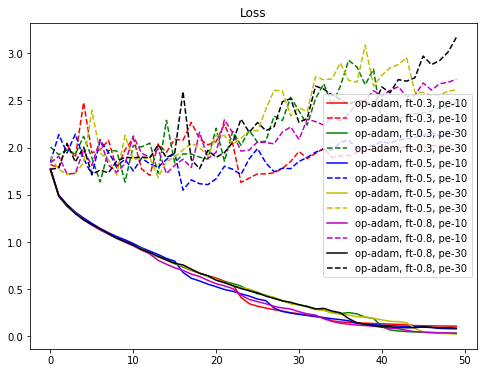

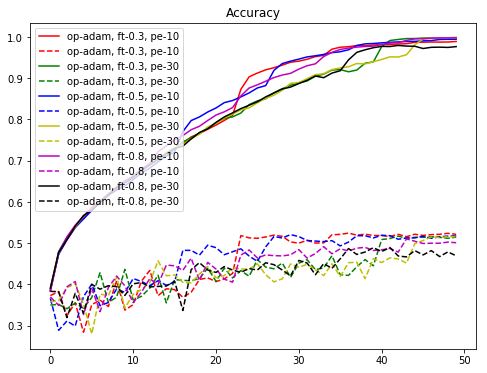



Experiment with optimizer = RMSprop, factor = 0.3, patience = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_nor

50000/50000 [==============================] - 2s 47us/step - loss: 0.2337 - acc: 0.9502 - val_loss: 1.8393 - val_acc: 0.5299
Epoch 48/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.2321 - acc: 0.9508 - val_loss: 1.8438 - val_acc: 0.5295
Epoch 49/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.2300 - acc: 0.9511 - val_loss: 1.8471 - val_acc: 0.5302
Epoch 50/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.2295 - acc: 0.9515 - val_loss: 1.8546 - val_acc: 0.5279


Experiment with optimizer = RMSprop, factor = 0.3, patience = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_______________________________________________________________

50000/50000 [==============================] - 2s 46us/step - loss: 0.3299 - acc: 0.8883 - val_loss: 2.6390 - val_acc: 0.4299
Epoch 46/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3144 - acc: 0.8956 - val_loss: 2.8666 - val_acc: 0.4087
Epoch 47/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.3114 - acc: 0.8952 - val_loss: 2.5736 - val_acc: 0.4425
Epoch 48/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.2982 - acc: 0.8999 - val_loss: 2.7116 - val_acc: 0.4423
Epoch 49/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.2849 - acc: 0.9058 - val_loss: 3.1512 - val_acc: 0.4049

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 50/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.1513 - acc: 0.9647 - val_loss: 2.2433 - val_acc: 0.4992


Experiment with optimizer = RMSprop, factor = 0.5, patience = 10
____________________________________

Epoch 42/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.2227 - acc: 0.9461 - val_loss: 2.0031 - val_acc: 0.5088

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 43/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.1907 - acc: 0.9606 - val_loss: 2.0014 - val_acc: 0.5204
Epoch 44/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1830 - acc: 0.9631 - val_loss: 1.9972 - val_acc: 0.5164
Epoch 45/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1765 - acc: 0.9661 - val_loss: 2.0092 - val_acc: 0.5248
Epoch 46/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1715 - acc: 0.9671 - val_loss: 2.0333 - val_acc: 0.5184
Epoch 47/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1644 - acc: 0.9695 - val_loss: 2.0768 - val_acc: 0.5213
Epoch 48/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.1597 - ac

Epoch 40/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.3817 - acc: 0.8705 - val_loss: 2.4900 - val_acc: 0.4384
Epoch 41/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3637 - acc: 0.8766 - val_loss: 2.6517 - val_acc: 0.4258
Epoch 42/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3614 - acc: 0.8764 - val_loss: 2.7561 - val_acc: 0.4129
Epoch 43/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3475 - acc: 0.8809 - val_loss: 2.6244 - val_acc: 0.4195
Epoch 44/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.3335 - acc: 0.8868 - val_loss: 2.8599 - val_acc: 0.4263
Epoch 45/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3245 - acc: 0.8909 - val_loss: 2.8574 - val_acc: 0.4072
Epoch 46/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.3189 - acc: 0.8916 - val_loss: 3.6651 - val_acc: 0.3803
Epoch 47/50
50000/50000 [=========

50000/50000 [==============================] - 2s 47us/step - loss: 0.3210 - acc: 0.9006 - val_loss: 2.3886 - val_acc: 0.4469
Epoch 37/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3041 - acc: 0.9088 - val_loss: 2.3384 - val_acc: 0.4685
Epoch 38/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.2870 - acc: 0.9135 - val_loss: 2.1830 - val_acc: 0.4747
Epoch 39/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.2775 - acc: 0.9164 - val_loss: 2.2516 - val_acc: 0.4660
Epoch 40/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.2650 - acc: 0.9227 - val_loss: 2.2316 - val_acc: 0.4741
Epoch 41/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.2527 - acc: 0.9254 - val_loss: 2.3848 - val_acc: 0.4657
Epoch 42/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.2454 - acc: 0.9266 - val_loss: 2.2805 - val_acc: 0.4873
Epoch 43/50
50000/50000 [=====================

Epoch 34/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.4817 - acc: 0.8341 - val_loss: 2.2598 - val_acc: 0.4352
Epoch 35/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.4664 - acc: 0.8399 - val_loss: 2.6802 - val_acc: 0.3704
Epoch 36/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.4455 - acc: 0.8472 - val_loss: 2.3472 - val_acc: 0.4572
Epoch 37/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.4351 - acc: 0.8509 - val_loss: 2.4888 - val_acc: 0.4256
Epoch 38/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.4167 - acc: 0.8573 - val_loss: 2.2088 - val_acc: 0.4533
Epoch 39/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.4142 - acc: 0.8583 - val_loss: 2.3949 - val_acc: 0.4314
Epoch 40/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.3938 - acc: 0.8643 - val_loss: 3.0607 - val_acc: 0.3743
Epoch 41/50
50000/50000 [=========

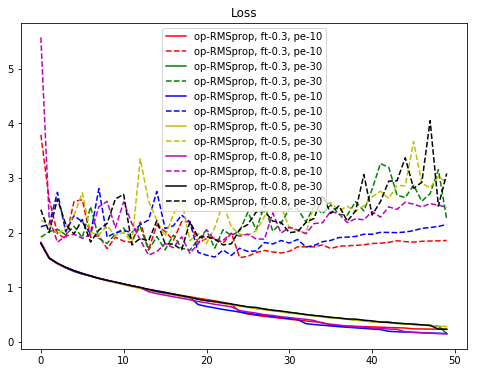

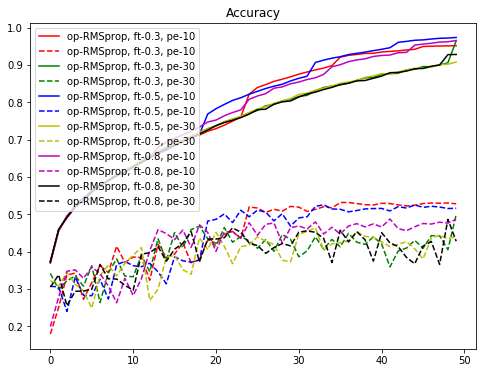

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

for op in OPTIMIZERS:
    results = {}
    for ft in FACTOR:
        for pe in PATIENCE:
            keras.backend.clear_session() # 把舊的 Graph 清掉
            print("\n\nExperiment with optimizer = %s, factor = %.1f, patience = %d" % (op, ft, pe))
            model = build_mlp(input_shape=x_train.shape[1:])
            model.summary()

            if (op=='sgd'):
                optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=SGD_MOMENTUM)
            elif (op=='adam'):
                optimizer = optimizers.Adam(lr=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2, \
                                            epsilon=None, decay=0, amsgrad=False)
            elif (op=='RMSprop'):
                optimizer = optimizers.RMSprop(lr=LEARNING_RATE, rho = RMSPROP_RHO, epsilon = None, decay = False)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            # 當監測數據變化小時, 減少學習率
            reduce_lr = ReduceLROnPlateau(factor=ft,  # 每次減少學習率的因子，學習率將以lr=lr*factor的形式減少
                                          min_lr=1e-12, # 學習率的下限
                                          monitor='val_loss',  # 被監測的數據
                                          patience=pe, # 當 patience 個 epoch 過去而模型性能不提升時，學習率減少的動作會被觸發
                                          verbose=1 # 資訊顯示
                                         )


            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True,
                      callbacks=[reduce_lr]
                     )

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]

            exp_name_tag = "op-%s, ft-%.1f, pe-%d" % (op, ft, pe)
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}  
    showPicture(results)